In [2]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import warnings
warnings.filterwarnings('ignore')

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

100%|██████████| 428M/428M [00:41<00:00, 10.8MB/s] 

Extracting model files...


Path to dataset files: C:\Users\ml_te\.cache\kagglehub\datasets\ejlok1\toronto-emotional-speech-set-tess\versions\1


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import speech_recognition as sr
from parselmouth import praat
from pydub import AudioSegment


# Function to extract features from an audio file
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)
    
    # Pitch (Fundamental Frequency)
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches[np.nonzero(pitches)]) if np.any(pitches) else 0
    
    # Intensity (Root Mean Square Energy)
    rms = librosa.feature.rms(y=y)
    intensity = np.mean(rms)
    
    # Frequency
    frequency = pitch

    # Amplitude
    amplitude = np.max(np.abs(y))
    
    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Spectral Features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    spectral_flux = np.mean(np.diff(librosa.stft(y), axis=1))

    # Energy
    energy = intensity  # RMS is synonymous with intensity for energy here
    
    # Jitter and Shimmer (using parselmouth and Praat)
    try:
        sound = praat.Sound(audio_path)
        point_process = praat.call(sound, "To PointProcess (periodic, cc)", 75, 500)
        jitter = praat.call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
        shimmer = praat.call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3)
    except:
        jitter = None
        shimmer = None
    
    # Zero-Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))

    # Tempo and Rhythm
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    
    # Formants (F1, F2, F3)
    formants = extract_formants(audio_path)

    return {
        "Pitch": pitch,
        "Intensity": intensity,
        "Frequency": frequency,
        "Amplitude": amplitude,
        "MFCCs": mfccs_mean.tolist(),
        "Spectral Centroid": spectral_centroid,
        "Spectral Bandwidth": spectral_bandwidth,
        "Spectral Rolloff": spectral_rolloff,
        "Spectral Flux": spectral_flux,
        "Energy": energy,
        "Jitter": jitter,
        "Shimmer": shimmer,
        "ZCR": zcr,
        "Tempo": tempo[0] if len(tempo) > 0 else None,
        "Formants": formants
    }


# Function to extract formants using parselmouth and Praat
def extract_formants(audio_path):
    try:
        sound = praat.Sound(audio_path)
        formant_object = praat.call(sound, "To Formant (burg)", 0.0, 5, 5000, 0.025, 50)
        f1 = praat.call(formant_object, "Get value at time", 1, 0.5, "Hertz", "Linear")
        f2 = praat.call(formant_object, "Get value at time", 2, 0.5, "Hertz", "Linear")
        f3 = praat.call(formant_object, "Get value at time", 3, 0.5, "Hertz", "Linear")
        return {"F1": f1, "F2": f2, "F3": f3}
    except:
        return {"F1": None, "F2": None, "F3": None}


# Function to transcribe the audio to text
def transcribe_audio(audio_path):
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)
    
    with audio as source:
        audio_data = recognizer.record(source)
        
    try:
        text = recognizer.recognize_google(audio_data)
    except sr.UnknownValueError:
        text = "Unable to transcribe"
    except sr.RequestError as e:
        text = f"Error: {e}"
    
    return text


# Function to process audio files and save extracted features to Excel
def process_audio_files(input_parent_folder, output_folder):
    data = []  # To store data for DataFrame

    for subfolder in os.listdir(input_parent_folder):
        subfolder_path = os.path.join(input_parent_folder, subfolder)
        
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.wav'):
                    audio_path = os.path.join(subfolder_path, filename)
                    print(f"Processing file: {audio_path}")
                    
                    # Extract features
                    features = extract_features(audio_path)
                    text = transcribe_audio(audio_path)
                    
                    # Store in DataFrame
                    data.append({
                        "Folder": subfolder,
                        "Filename": filename,
                        **features,
                        "Text": text
                    })
    
    # Create and save DataFrame
    df = pd.DataFrame(data)
    output_excel_path = os.path.join(output_folder, 'features.xlsx')
    df.to_excel(output_excel_path, index=False)
    print(f"Excel file saved at: {output_excel_path}")


# Define input and output directories
input_parent_folder = 'C://Users//ml_te//voice_datasets'  # Parent folder containing audio files
output_folder = 'C://Users//ml_te//datasets_data'  # Destination for dataset

# Run processing
process_audio_files(input_parent_folder, output_folder)


Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_back_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_bar_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_base_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_bath_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_bean_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_beg_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_bite_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_boat_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_bone_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_book_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_bought_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OAF_angry\OAF_burn_angry.wav
Processing file: C://Users//ml_te//voice_datasets\OA

In [8]:
# import os
# import librosa
# import numpy as np
# import speech_recognition as sr
# import pandas as pd
# from pydub import AudioSegment
# import shutil

# # Function to extract pitch and intensity from an audio file
# def extract_features(audio_path):
#     y, sr = librosa.load(audio_path, sr=None)
    
#     # Extract pitch (using librosa's pitch extraction method)
#     pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
#     pitch = np.mean(pitches)
    
#     # Extract intensity (root mean square energy)
#     rms = librosa.feature.rms(y=y)
#     intensity = np.mean(rms)  # Intensity as a float value
    
#     return pitch, intensity

# # Function to transcribe the audio to text
# def transcribe_audio(audio_path):
#     recognizer = sr.Recognizer()
#     audio = sr.AudioFile(audio_path)
    
#     with audio as source:
#         audio_data = recognizer.record(source)
        
#     try:
#         text = recognizer.recognize_google(audio_data)
#     except sr.UnknownValueError:
#         text = "Unable to transcribe"
#     except sr.RequestError as e:
#         text = f"Error: {e}"
    
#     return text

# # Function to organize audio files based on the level and extract features
# def process_audio_files(input_parent_folder, output_folder):
#     # Prepare a list to store data for the DataFrame
#     data = []

#     # Process each subfolder (data folder) in the parent folder
#     for subfolder in os.listdir(input_parent_folder):
#         subfolder_path = os.path.join(input_parent_folder, subfolder)
        
#         if os.path.isdir(subfolder_path):
#             print(f"Processing folder: {subfolder_path}")
            
#             # Process each audio file in the current subfolder
#             for filename in os.listdir(subfolder_path):
#                 if filename.endswith('.wav'):
#                     audio_path = os.path.join(subfolder_path, filename)
                    
#                     # Extract features
#                     pitch, intensity = extract_features(audio_path)
#                     text = transcribe_audio(audio_path)
                    
#                     # Create an entry for the current file
#                     data.append({
#                         "Folder": subfolder,
#                         "Filename": filename,
#                         "Pitch": pitch,
#                         "Intensity": intensity,
#                         "Text": text
#                     })
    
#     # Create a DataFrame from the collected data
#     df = pd.DataFrame(data)
    
#     # Save the DataFrame to an Excel file
#     output_excel_path = os.path.join(output_folder, 'audio_features.xlsx')
#     df.to_excel(output_excel_path, index=False)

#     print(f"Excel file saved at: {output_excel_path}")

# # Define the input and output directories
# input_parent_folder = 'C://Users//ml_te//voice_datasets'  # Replace with the path to your parent folder containing multiple subdirectories
# output_folder = 'C://Users//ml_te//datasets_data'  # Replace with the path where you want the dataset organized

# # Run the function to process the files and save the data to Excel
# process_audio_files(input_parent_folder, output_folder)


Processing folder: C://Users//ml_te//voice_datasets\OAF_angry
Processing folder: C://Users//ml_te//voice_datasets\OAF_disgust
Processing folder: C://Users//ml_te//voice_datasets\OAF_Fear
Processing folder: C://Users//ml_te//voice_datasets\OAF_happy
Processing folder: C://Users//ml_te//voice_datasets\OAF_neutral
Processing folder: C://Users//ml_te//voice_datasets\OAF_Pleasant_surprise
Processing folder: C://Users//ml_te//voice_datasets\OAF_Sad
Processing folder: C://Users//ml_te//voice_datasets\TESS Toronto emotional speech set data
Processing folder: C://Users//ml_te//voice_datasets\YAF_angry
Processing folder: C://Users//ml_te//voice_datasets\YAF_disgust
Processing folder: C://Users//ml_te//voice_datasets\YAF_fear
Processing folder: C://Users//ml_te//voice_datasets\YAF_happy
Processing folder: C://Users//ml_te//voice_datasets\YAF_neutral
Processing folder: C://Users//ml_te//voice_datasets\YAF_pleasant_surprised
Processing folder: C://Users//ml_te//voice_datasets\YAF_sad
Excel file sav

In [4]:
df=pd.read_excel("C://Users//ml_te//datasets_data//features.xlsx")

In [5]:
df.head()

,Folder,Filename,Pitch,Intensity,Frequency,Amplitude,MFCCs,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flux,Energy,Jitter,Shimmer,ZCR,Tempo,Formants,Text
0,OAF_angry,OAF_back_angry.wav,1410.588989,0.041406,1410.588989,0.337341,"[-390.0313415527344, 55.235965728759766, -15.0...",2244.518922,2417.499675,4023.786502,(7.856366210035048e-06-8.686884029884823e-07j),0.041406,NaN,NaN,0.081048,143.050781,"{'F1': None, 'F2': None, 'F3': None}",say the word
1,OAF_angry,OAF_bar_angry.wav,1168.005859,0.022364,1168.005859,0.176117,"[-451.01947021484375, 67.048828125, -0.4482572...",2182.569100,2405.502339,3817.591309,(7.408749752357835e-06-2.919421149272239e-07j),0.022364,NaN,NaN,0.085180,130.046165,"{'F1': None, 'F2': None, 'F3': None}",say the word
2,OAF_angry,OAF_base_angry.wav,1863.138916,0.029732,1863.138916,0.265015,"[-406.5633239746094, 28.609004974365234, -5.31...",2964.378675,2675.259261,5331.541280,(-3.4756992590700975e-06-8.736076779314317e-06j),0.029732,NaN,NaN,0.127679,143.050781,"{'F1': None, 'F2': None, 'F3': None}",say the word
3,OAF_angry,OAF_bath_angry.wav,1489.154175,0.043054,1489.154175,0.343719,"[-386.34002685546875, 53.43965530395508, -8.66...",2636.422929,2515.913088,4431.942332,(-1.4807430943619693e-06-3.374229663677397e-06j),0.043054,NaN,NaN,0.105919,95.367188,"{'F1': None, 'F2': None, 'F3': None}",say the word
4,OAF_angry,OAF_bean_angry.wav,1090.847290,0.030544,1090.847290,0.282318,"[-404.7848815917969, 54.46256637573242, 3.3552...",2330.168832,2432.395141,4295.259839,(5.316106125974329e-06+1.038062237057602e-05j),0.030544,NaN,NaN,0.076019,110.039062,"{'F1': None, 'F2': None, 'F3': None}",say the word


In [6]:
df['Emotion'] = df['Folder'].apply(lambda x: x.split('_')[-1].lower() if len(x.split('_')) > 1 else x.lower())
df.head()

,Folder,Filename,Pitch,Intensity,Frequency,Amplitude,MFCCs,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flux,Energy,Jitter,Shimmer,ZCR,Tempo,Formants,Text,Emotion
0,OAF_angry,OAF_back_angry.wav,1410.588989,0.041406,1410.588989,0.337341,"[-390.0313415527344, 55.235965728759766, -15.0...",2244.518922,2417.499675,4023.786502,(7.856366210035048e-06-8.686884029884823e-07j),0.041406,NaN,NaN,0.081048,143.050781,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry
1,OAF_angry,OAF_bar_angry.wav,1168.005859,0.022364,1168.005859,0.176117,"[-451.01947021484375, 67.048828125, -0.4482572...",2182.569100,2405.502339,3817.591309,(7.408749752357835e-06-2.919421149272239e-07j),0.022364,NaN,NaN,0.085180,130.046165,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry
2,OAF_angry,OAF_base_angry.wav,1863.138916,0.029732,1863.138916,0.265015,"[-406.5633239746094, 28.609004974365234, -5.31...",2964.378675,2675.259261,5331.541280,(-3.4756992590700975e-06-8.736076779314317e-06j),0.029732,NaN,NaN,0.127679,143.050781,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry
3,OAF_angry,OAF_bath_angry.wav,1489.154175,0.043054,1489.154175,0.343719,"[-386.34002685546875, 53.43965530395508, -8.66...",2636.422929,2515.913088,4431.942332,(-1.4807430943619693e-06-3.374229663677397e-06j),0.043054,NaN,NaN,0.105919,95.367188,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry
4,OAF_angry,OAF_bean_angry.wav,1090.847290,0.030544,1090.847290,0.282318,"[-404.7848815917969, 54.46256637573242, 3.3552...",2330.168832,2432.395141,4295.259839,(5.316106125974329e-06+1.038062237057602e-05j),0.030544,NaN,NaN,0.076019,110.039062,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry


In [7]:
df["Emotion"].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'surprise', 'sad',
       'surprised'], dtype=object)

In [8]:
# Define a dictionary to map emotions to stress levels
emotion_to_stress = {
    "angry": 9,
    "fear": 8,
    "sad": 4,
    "happy": 2,
    "disgust": 6,
    "neutral": 1,
    "surprise": 5,
    "surprised": 5
}

# Create a new "Stress" column based on the Emotion column
df["Stress"] = df["Emotion"].map(emotion_to_stress)

# Display the DataFrame with the new Stress column


In [9]:
df.head()

,Folder,Filename,Pitch,Intensity,Frequency,Amplitude,MFCCs,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flux,Energy,Jitter,Shimmer,ZCR,Tempo,Formants,Text,Emotion,Stress
0,OAF_angry,OAF_back_angry.wav,1410.588989,0.041406,1410.588989,0.337341,"[-390.0313415527344, 55.235965728759766, -15.0...",2244.518922,2417.499675,4023.786502,(7.856366210035048e-06-8.686884029884823e-07j),0.041406,NaN,NaN,0.081048,143.050781,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry,9
1,OAF_angry,OAF_bar_angry.wav,1168.005859,0.022364,1168.005859,0.176117,"[-451.01947021484375, 67.048828125, -0.4482572...",2182.569100,2405.502339,3817.591309,(7.408749752357835e-06-2.919421149272239e-07j),0.022364,NaN,NaN,0.085180,130.046165,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry,9
2,OAF_angry,OAF_base_angry.wav,1863.138916,0.029732,1863.138916,0.265015,"[-406.5633239746094, 28.609004974365234, -5.31...",2964.378675,2675.259261,5331.541280,(-3.4756992590700975e-06-8.736076779314317e-06j),0.029732,NaN,NaN,0.127679,143.050781,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry,9
3,OAF_angry,OAF_bath_angry.wav,1489.154175,0.043054,1489.154175,0.343719,"[-386.34002685546875, 53.43965530395508, -8.66...",2636.422929,2515.913088,4431.942332,(-1.4807430943619693e-06-3.374229663677397e-06j),0.043054,NaN,NaN,0.105919,95.367188,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry,9
4,OAF_angry,OAF_bean_angry.wav,1090.847290,0.030544,1090.847290,0.282318,"[-404.7848815917969, 54.46256637573242, 3.3552...",2330.168832,2432.395141,4295.259839,(5.316106125974329e-06+1.038062237057602e-05j),0.030544,NaN,NaN,0.076019,110.039062,"{'F1': None, 'F2': None, 'F3': None}",say the word,angry,9


In [11]:
# List of columns to drop
columns_to_drop = ['Folder', 'Filename', 'Jitter', 'Shimmer', 'Formants', 'Text', 'Emotion']

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Display the updated DataFrame
print(df.head())


         Pitch  Intensity    Frequency  Amplitude  \
0  1410.588989   0.041406  1410.588989   0.337341   
1  1168.005859   0.022364  1168.005859   0.176117   
2  1863.138916   0.029732  1863.138916   0.265015   
3  1489.154175   0.043054  1489.154175   0.343719   
4  1090.847290   0.030544  1090.847290   0.282318   

                                               MFCCs  Spectral Centroid  \
0  [-390.0313415527344, 55.235965728759766, -15.0...        2244.518922   
1  [-451.01947021484375, 67.048828125, -0.4482572...        2182.569100   
2  [-406.5633239746094, 28.609004974365234, -5.31...        2964.378675   
3  [-386.34002685546875, 53.43965530395508, -8.66...        2636.422929   
4  [-404.7848815917969, 54.46256637573242, 3.3552...        2330.168832   

   Spectral Bandwidth  Spectral Rolloff  \
0         2417.499675       4023.786502   
1         2405.502339       3817.591309   
2         2675.259261       5331.541280   
3         2515.913088       4431.942332   
4         2432.

In [12]:
df.head()

,Pitch,Intensity,Frequency,Amplitude,MFCCs,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Spectral Flux,Energy,ZCR,Tempo,Stress
0,1410.588989,0.041406,1410.588989,0.337341,"[-390.0313415527344, 55.235965728759766, -15.0...",2244.518922,2417.499675,4023.786502,(7.856366210035048e-06-8.686884029884823e-07j),0.041406,0.081048,143.050781,9
1,1168.005859,0.022364,1168.005859,0.176117,"[-451.01947021484375, 67.048828125, -0.4482572...",2182.569100,2405.502339,3817.591309,(7.408749752357835e-06-2.919421149272239e-07j),0.022364,0.085180,130.046165,9
2,1863.138916,0.029732,1863.138916,0.265015,"[-406.5633239746094, 28.609004974365234, -5.31...",2964.378675,2675.259261,5331.541280,(-3.4756992590700975e-06-8.736076779314317e-06j),0.029732,0.127679,143.050781,9
3,1489.154175,0.043054,1489.154175,0.343719,"[-386.34002685546875, 53.43965530395508, -8.66...",2636.422929,2515.913088,4431.942332,(-1.4807430943619693e-06-3.374229663677397e-06j),0.043054,0.105919,95.367188,9
4,1090.847290,0.030544,1090.847290,0.282318,"[-404.7848815917969, 54.46256637573242, 3.3552...",2330.168832,2432.395141,4295.259839,(5.316106125974329e-06+1.038062237057602e-05j),0.030544,0.076019,110.039062,9


# preprocess

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


In [23]:
# Check if any column contains NaN or null values
df.isnull().any()

Pitch                 False
Intensity             False
Frequency             False
Amplitude             False
MFCCs                 False
Spectral Centroid     False
Spectral Bandwidth    False
Spectral Rolloff      False
Spectral Flux         False
Energy                False
ZCR                   False
Tempo                 False
Stress                False
dtype: bool

In [21]:
def average_mfcc(mfcc_str):
    # Convert the string representation of list to actual list
    mfcc_list = ast.literal_eval(mfcc_str)
    # Calculate the average of the list
    return np.mean(mfcc_list)

df['MFCCs'] = df['MFCCs'].apply(average_mfcc)

In [25]:
# Convert the 'Spectral Flux' column to complex numbers if they are in string format
df['Spectral Flux'] = df['Spectral Flux'].apply(lambda x: complex(x) if isinstance(x, str) else x)

# Now calculate the magnitude (absolute value) of the complex numbers
df['Spectral Flux Magnitude'] = df['Spectral Flux'].apply(lambda x: abs(x))


In [27]:
# Drop the 'Spectral Flux' column from the DataFrame
df = df.drop(columns=['Spectral Flux'])


In [28]:
df.head()

,Pitch,Intensity,Frequency,Amplitude,MFCCs,Spectral Centroid,Spectral Bandwidth,Spectral Rolloff,Energy,ZCR,Tempo,Stress,Spectral Flux Magnitude
0,1410.588989,0.041406,1410.588989,0.337341,-30.948066,2244.518922,2417.499675,4023.786502,0.041406,0.081048,143.050781,9,0.000008
1,1168.005859,0.022364,1168.005859,0.176117,-32.540100,2182.569100,2405.502339,3817.591309,0.022364,0.085180,130.046165,9,0.000007
2,1863.138916,0.029732,1863.138916,0.265015,-32.537548,2964.378675,2675.259261,5331.541280,0.029732,0.127679,143.050781,9,0.000009
3,1489.154175,0.043054,1489.154175,0.343719,-30.635308,2636.422929,2515.913088,4431.942332,0.043054,0.105919,95.367188,9,0.000004
4,1090.847290,0.030544,1090.847290,0.282318,-30.589720,2330.168832,2432.395141,4295.259839,0.030544,0.076019,110.039062,9,0.000012


In [29]:
#data split
X = df.drop(columns=['Stress'])
y = df['Stress']

#feature selection

Feature Importance (Percentage):
                     Feature       Score  Score Percentage
0                     Pitch  109.533977         46.558552
1                 Intensity  201.722409         85.744200
2                 Frequency  109.533977         46.558552
3                 Amplitude  235.260704        100.000000
4                     MFCCs   24.063334         10.228369
5         Spectral Centroid   91.840289         39.037666
6        Spectral Bandwidth   94.941430         40.355839
7          Spectral Rolloff  114.462450         48.653450
8                    Energy  201.722409         85.744200
9                       ZCR   64.025727         27.214799
10                    Tempo   70.346124         29.901349
11  Spectral Flux Magnitude   14.524479          6.173780


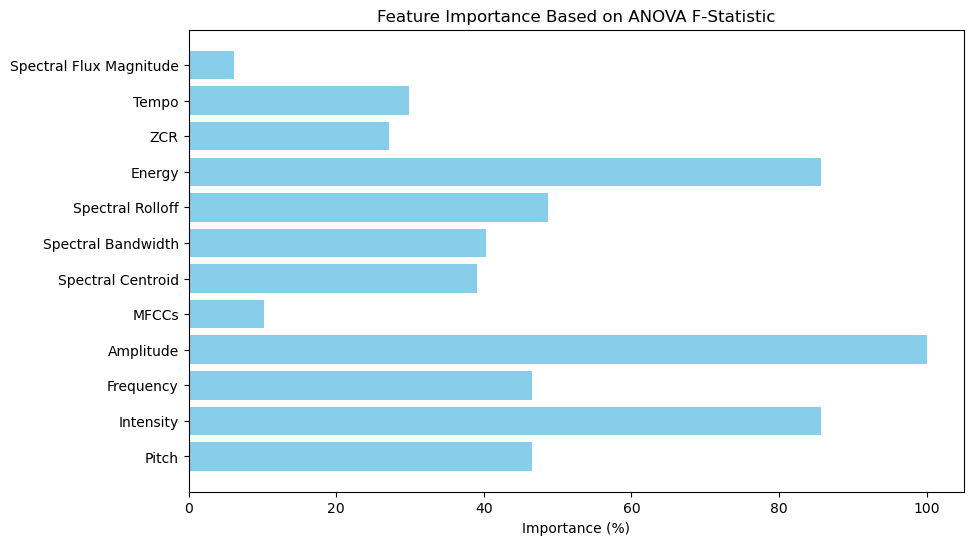

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif
# Step 2: Perform Feature Selection (Select top 8 features using ANOVA F-statistic)
selector = SelectKBest(score_func=f_classif, k='all')  # 'k=all' to keep all features
X_selected = selector.fit_transform(X, y)

# Step 3: Get the feature scores and normalize them to get percentages
feature_scores = selector.scores_
max_score = max(feature_scores)
feature_scores_percentage = [score / max_score * 100 for score in feature_scores]

# Step 4: Create a DataFrame to show feature scores and percentages
selected_features_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_scores,
    'Score Percentage': feature_scores_percentage
})

# Display the selected features and their importance
print("Feature Importance (Percentage):\n", selected_features_df)

# Step 5: Visualization (Bar plot of feature importance)
plt.figure(figsize=(10, 6))
plt.barh(selected_features_df['Feature'], selected_features_df['Score Percentage'], color='skyblue')
plt.xlabel('Importance (%)')
plt.title('Feature Importance Based on ANOVA F-Statistic')
plt.show()

In [39]:
#finalize column
# List of selected columns
selected_columns = [
    'Intensity',
    'Amplitude',
    'Spectral Centroid',
    'Spectral Bandwidth',
    'Spectral Rolloff',
    'Energy',
    'Pitch',
    'Frequency'
]

# Filter the DataFrame to keep only the selected columns
X_selected = X[selected_columns]

# Display the resulting DataFrame
print(X_selected.head())


   Intensity  Amplitude  Spectral Centroid  Spectral Bandwidth  \
0   0.041406   0.337341        2244.518922         2417.499675   
1   0.022364   0.176117        2182.569100         2405.502339   
2   0.029732   0.265015        2964.378675         2675.259261   
3   0.043054   0.343719        2636.422929         2515.913088   
4   0.030544   0.282318        2330.168832         2432.395141   

   Spectral Rolloff    Energy        Pitch    Frequency  
0       4023.786502  0.041406  1410.588989  1410.588989  
1       3817.591309  0.022364  1168.005859  1168.005859  
2       5331.541280  0.029732  1863.138916  1863.138916  
3       4431.942332  0.043054  1489.154175  1489.154175  
4       4295.259839  0.030544  1090.847290  1090.847290  


In [48]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [49]:
print(len(X_train), len(X_test))

2240 560


In [50]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# traditional machine learning model 

In [51]:
# SVC Model
svc_model = SVC(kernel='rbf')
svc_model.fit(X_train, y_train)
svc_predictions = svc_model.predict(X_test)
print("SVC Accuracy:", accuracy_score(y_test, svc_predictions))
print(classification_report(y_test, svc_predictions))

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

SVC Accuracy: 0.6714285714285714
              precision    recall  f1-score   support

           1       0.62      0.77      0.68        73
           2       0.60      0.71      0.65        77
           4       0.74      0.55      0.63        82
           5       0.60      0.64      0.62        87
           6       0.76      0.73      0.75        78
           8       0.73      0.67      0.70        89
           9       0.71      0.64      0.67        74

    accuracy                           0.67       560
   macro avg       0.68      0.67      0.67       560
weighted avg       0.68      0.67      0.67       560

Random Forest Accuracy: 0.7267857142857143
              precision    recall  f1-score   support

           1       0.83      0.74      0.78        73
           2       0.61      0.73      0.66        77
           4       0.78      0.82      0.80        82
           5       0.63      0.66      0.64        87
           6       0.78      0.77      0.77        78
  

# CNN model 

In [53]:
X_scaled = scaler.fit_transform(X)

print(X_scaled)

[[-0.47551382  0.58762502 -0.47551382 ... -1.11005622  0.76803954
   0.37982777]
 [-1.15943724 -0.44187184 -1.15943724 ... -1.03141218  0.2154015
   0.31091928]
 [ 0.80037662 -0.043507    0.80037662 ... -0.22252363  0.76803954
   0.59057947]
 ...
 [-2.70469165  0.662916   -2.70469165 ...  0.41999564 -1.25829996
  -0.41738433]
 [-1.53234058 -0.10110286 -1.53234058 ... -0.52452091 -1.38903154
  -0.58921565]
 [-0.85374127 -0.05422649 -0.85374127 ...  0.25295812  1.84080751
  -0.11823656]]


In [54]:
# Reshape the data for the CNN input (e.g., [batch_size, channels, height, width])
# Here, we assume 1 channel, and the features can be treated as a 2D input (for example, each row is a feature vector).
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1], 1)  # [samples, channels, feature_size, 1]

In [55]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Convert NumPy arrays and pandas Series to PyTorch tensors
X_train_tensor = torch.tensor(X_train1, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test1, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train1.to_numpy(), dtype=torch.long)  # Convert Series to NumPy array
y_test_tensor = torch.tensor(y_test1.to_numpy(), dtype=torch.long)    # Convert Series to NumPy array

In [72]:
print(X_train_tensor.shape)  # Should be (num_samples, 12)
print(y_train_tensor.shape)  # Should be (num_samples,)

torch.Size([2240, 1, 12, 1])
torch.Size([2240])


In [74]:
num_classes = len(torch.unique(y_train_tensor))
print("number", num_classes)

number 7


In [76]:

class CNNFusionModel(nn.Module):
    def __init__(self, input_dim=12, num_classes=7):
        super(CNNFusionModel, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, input_dim)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [82]:
from torch.optim.lr_scheduler import StepLR

# Map labels to a continuous range
unique_classes = torch.unique(y_train_tensor)
class_mapping = {old: new for new, old in enumerate(unique_classes.tolist())}
y_train_tensor = torch.tensor([class_mapping[label.item()] for label in y_train_tensor])

# Verify the new unique values and number of classes
print("Mapped unique values in y_train_tensor:", torch.unique(y_train_tensor))
num_classes = len(torch.unique(y_train_tensor))
print("Number of classes:", num_classes)

# Define the model with the correct number of classes
model = CNNFusionModel(input_dim=12, num_classes=num_classes)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Update optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop with scheduler
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()
    print(f"Epoch [{epoch+1}/20], Loss: {loss.item():.4f}")



Mapped unique values in y_train_tensor: tensor([0, 1, 2, 3, 4, 5, 6])
Number of classes: 7
Epoch [1/20], Loss: 1.9483
Epoch [2/20], Loss: 1.9379
Epoch [3/20], Loss: 1.9195
Epoch [4/20], Loss: 1.9088
Epoch [5/20], Loss: 1.8918
Epoch [6/20], Loss: 1.8896
Epoch [7/20], Loss: 1.8734
Epoch [8/20], Loss: 1.8698
Epoch [9/20], Loss: 1.8627
Epoch [10/20], Loss: 1.8594
Epoch [11/20], Loss: 1.8476
Epoch [12/20], Loss: 1.8410
Epoch [13/20], Loss: 1.8454
Epoch [14/20], Loss: 1.8403
Epoch [15/20], Loss: 1.8313
Epoch [16/20], Loss: 1.8305
Epoch [17/20], Loss: 1.8265
Epoch [18/20], Loss: 1.8178
Epoch [19/20], Loss: 1.8178
Epoch [20/20], Loss: 1.8163


In [83]:
model.eval()  # Set the model to evaluation mode

# Forward pass on test set
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Calculate accuracy
accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
print(f'Accuracy: {accuracy}%')


Accuracy: 0.11071428571428571%


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a CNN model
class StressCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(StressCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Define ReLU activation function
        self.relu = nn.ReLU()

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 3, 128)  # Adjusted size after calculating conv output
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First convolutional layer
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Second convolutional layer
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the tensor before passing to fully connected layers
        x = x.view(x.size(0), -1)  # Flatten to [batch_size, flattened_size]
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Example input tensor
X_train_tensor = torch.randn(2240, 1, 12)  # [batch_size, 1, input_dim]
y_train_tensor = torch.randint(0, 7, (2240,))  # [batch_size]

# Define the model, loss function, and optimizer
model = StressCNN(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (simplified)
model.train()
for epoch in range(2000):  # Adjust number of epochs as needed
    optimizer.zero_grad()
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
    correct = (predicted == y_train_tensor).sum().item()
    accuracy = correct / y_train_tensor.size(0) * 100  # Percentage accuracy

    # Print loss and accuracy every 100 epochs (or as needed)
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 1.9522, Accuracy: 13.84%
Epoch [2/10], Loss: 1.9451, Accuracy: 15.00%
Epoch [3/10], Loss: 1.9466, Accuracy: 16.47%
Epoch [4/10], Loss: 1.9424, Accuracy: 16.56%
Epoch [5/10], Loss: 1.9428, Accuracy: 16.03%
Epoch [6/10], Loss: 1.9432, Accuracy: 15.67%
Epoch [7/10], Loss: 1.9410, Accuracy: 16.25%
Epoch [8/10], Loss: 1.9388, Accuracy: 16.83%
Epoch [9/10], Loss: 1.9409, Accuracy: 16.25%
Epoch [10/10], Loss: 1.9393, Accuracy: 17.14%
Epoch [11/10], Loss: 1.9384, Accuracy: 16.52%
Epoch [12/10], Loss: 1.9363, Accuracy: 18.35%
Epoch [13/10], Loss: 1.9352, Accuracy: 17.28%
Epoch [14/10], Loss: 1.9346, Accuracy: 17.77%
Epoch [15/10], Loss: 1.9368, Accuracy: 17.72%
Epoch [16/10], Loss: 1.9324, Accuracy: 18.17%
Epoch [17/10], Loss: 1.9318, Accuracy: 19.42%
Epoch [18/10], Loss: 1.9308, Accuracy: 19.02%
Epoch [19/10], Loss: 1.9324, Accuracy: 18.93%
Epoch [20/10], Loss: 1.9299, Accuracy: 18.39%
Epoch [21/10], Loss: 1.9285, Accuracy: 19.24%
Epoch [22/10], Loss: 1.9271, Accuracy: 19.8

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Custom Dataset for loading XLSX data
class StressDataset(Dataset):
    def __init__(self, xlsx_file):
        self.data = pd.read_excel(xlsx_file)
        self.features = self.data.iloc[:, :-1].values  # Assuming last column is the label
        self.labels = self.data.iloc[:, -1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

# LSTM+CNN Model
class LSTM_CNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, cnn_channels, num_classes):
        super(LSTM_CNN_Model, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, bidirectional=True)
        
        # CNN Layer
        self.conv1 = nn.Conv1d(in_channels=hidden_dim * 2, out_channels=cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(cnn_channels * (input_dim // 2), 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x, _ = self.lstm(x)  # LSTM output
        x = x.permute(0, 2, 1)  # Prepare for CNN: (batch_size, channels, sequence_length)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_dim = 12  # Number of features
hidden_dim = 32
lstm_layers = 2
cnn_channels = 16
num_classes = 7
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Load the dataset

# Initialize Model, Loss, and Optimizer
model = LSTM_CNN_Model(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=lstm_layers,
                       cnn_channels=cnn_channels, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
    correct = (predicted == y_train_tensor).sum().item()
    accuracy = correct / y_train_tensor.size(0) * 100  # Percentage accuracy

    # Print loss and accuracy every 100 epochs (or as needed)
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")

        
        

NameError: name 'dataloader' is not defined

In [ ]:
df["stress"]
     if emotion == "angry":
        stress_level = 9
    elif emotion == "fear":
        stress_level = 8  
    elif emotion == "sad":
        stress_level = 4  
    elif emotion == "happy":
        stress_level = 2 
    elif emotion == "disgust":
        stress_level = 6 
    elif emotion == "neutral":
        stress_level = 1 
    elif emotion == "surprise" or emotion == "surprised":
        stress_level = 5 

In [4]:
# Step 1: Install Kaggle API
!pip install -q kaggle

# Step 2: Upload Kaggle API key (you need a Kaggle account and API token)
from google.colab import files
files.upload()  # Upload kaggle.json file (from Kaggle account)

# Step 3: Move kaggle.json into the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset using the correct identifier from the link
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

# Step 5: Unzip the downloaded dataset
!unzip -q toronto-emotional-speech-set-tess.zip -d /content/tess

# Step 6: Load paths and labels
import os

paths = []
labels = []
for dirname, _, filenames in os.walk('/content/tess'):
    for filename in filenames:
        if filename.endswith('.wav'):  # Add this line if the files are .wav audio files
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1]
            label = label.split('.')[0]
            labels.append(label.lower())
    if len(paths) == 2800:
        break

print('Dataset is Loaded')

# Step 7: Display some paths and labels to verify
print(f"Sample paths: {paths[:5]}")
print(f"Sample labels: {labels[:5]}")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ktrain 0.26.2 requires scikit-learn==0.23.2, but you have scikit-learn 1.2.1 which is incompatible.
ktrain 0.26.2 requires transformers<=4.3.3,>=4.0.0, but you have transformers 4.24.0 which is incompatible.
conda-repo-cli 1.0.27 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.27 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
len(paths)

2800

In [ ]:
paths[:5]  ## Displaying some sample paths

['/content/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_peg_fear.wav',
 '/content/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_dead_fear.wav',
 '/content/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_pool_fear.wav',
 '/content/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_rain_fear.wav',
 '/content/tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_near_fear.wav']

In [ ]:
labels[:5] # Displaying some sample labels

['fear', 'fear', 'fear', 'fear', 'fear']

In [ ]:
# Creating a DataFrame with speech file paths and their corresponding labels
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/tess/tess toronto emotional speech se...,fear
1,/content/tess/tess toronto emotional speech se...,fear
2,/content/tess/tess toronto emotional speech se...,fear
3,/content/tess/tess toronto emotional speech se...,fear
4,/content/tess/tess toronto emotional speech se...,fear


In [ ]:
# Creating a DataFrame with speech file paths and their corresponding labels
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/tess/tess toronto emotional speech se...,fear
1,/content/tess/tess toronto emotional speech se...,fear
2,/content/tess/tess toronto emotional speech se...,fear
3,/content/tess/tess toronto emotional speech se...,fear
4,/content/tess/tess toronto emotional speech se...,fear


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1uacBsNjZdb4Ceru9-sjz2AluFxLSv3hXKpPynuvSJA8#gid=0


In [ ]:
df['label'].value_counts()   # we can see its balance dataset

,count
label,
sad,400
neutral,400
fear,400
disgust,400
happy,400
ps,400
angry,400


<Axes: xlabel='label', ylabel='count'>

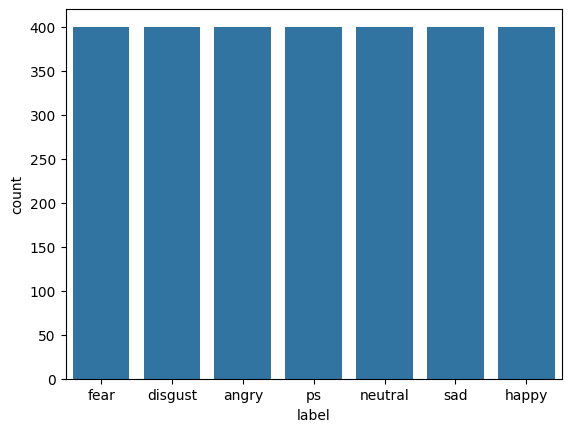

In [ ]:
sns.countplot(data=df, x='label')

In [ ]:
# Function to plot the waveform (loudness over time) of an audio signal
def waveplot(data, sr, emotion):
    plt.figure(figsize=(8,2))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)  # Displaying waveplot using librosa
    plt.show()

In [ ]:
# Function to plot the spectrogram (frequency spectrum) of an audio signal
def spectogram(data, sr, emotion):
    x = librosa.stft(data)  # Applying short-time Fourier transform
    xdb = librosa.amplitude_to_db(abs(x))  # Converting amplitude to decibels
    plt.figure(figsize=(8,2))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')  # Displaying spectrogram
    plt.colorbar()

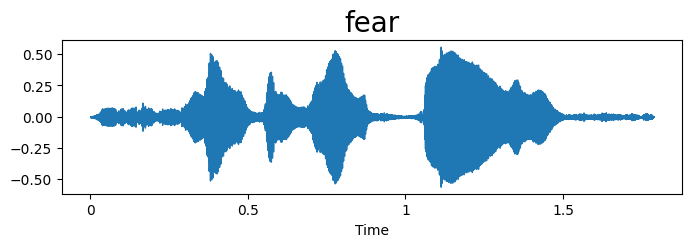

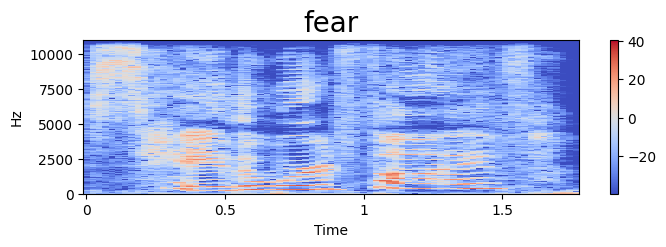

In [ ]:
# Example of waveplot and spectrogram for 'fear' emotion
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[210]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

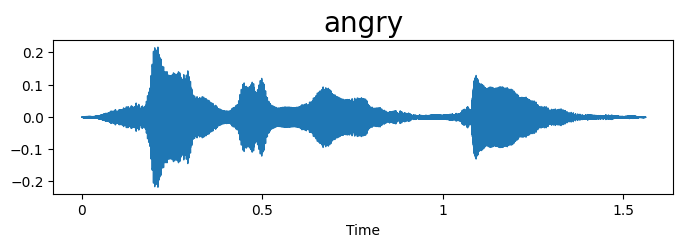

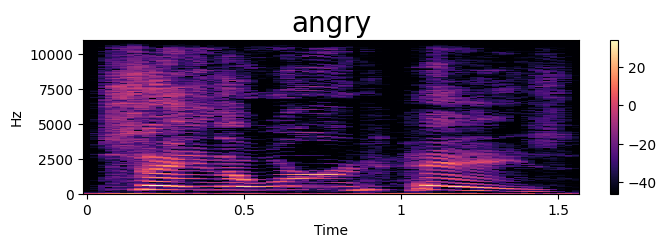

In [ ]:
# Example of waveplot and spectrogram for 'angry' emotion
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[150]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

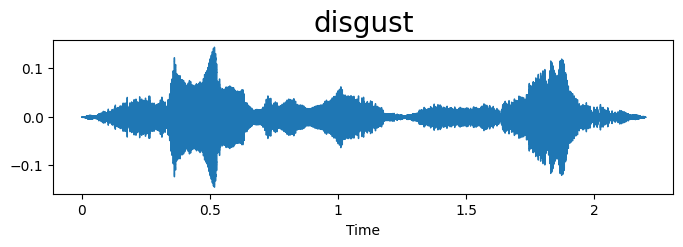

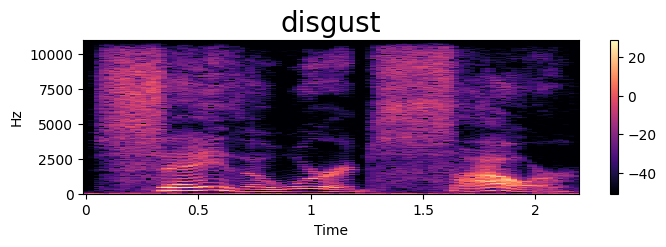

In [ ]:
# Example of waveplot and spectrogram for 'disgust' emotion
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[200]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

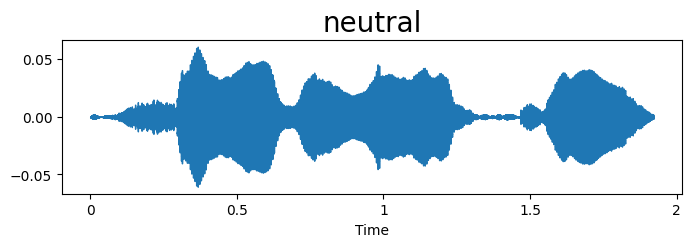

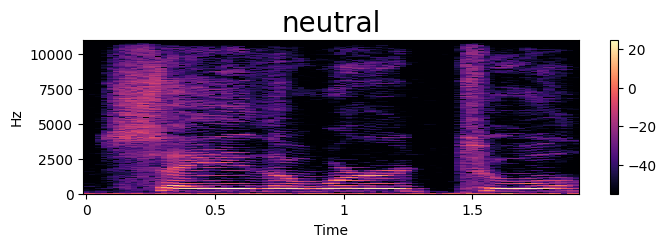

In [ ]:
# Example of waveplot and spectrogram for 'neutral' emotion
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[210]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

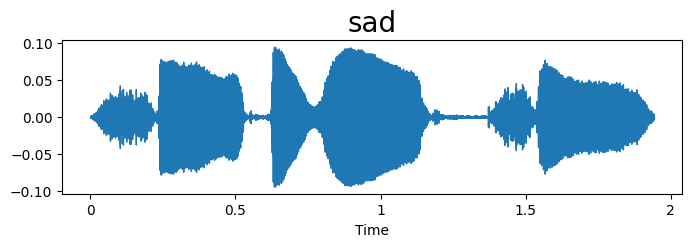

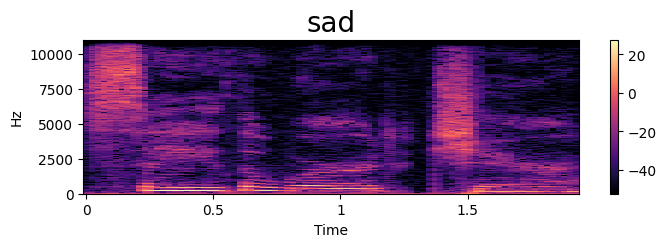

In [ ]:
# Example of waveplot and spectrogram for 'sad' emotion
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
################### # Data Augmentation Functions Adding more variations to the training data(tech: time_stretch, pitch_shift, noise injection,)
def augment_audio(data, sr):
    # Randomly apply one or more augmentations
    if np.random.random() < 0.5:
        data = librosa.effects.time_stretch(data, rate=np.random.uniform(0.8, 1.2))  # Time Stretching: Stretch or compress the audio without altering the pitch.
    # if np.random.random() < 0.5:          # Pitch Shifting: Modify the pitch of the audio.
    #     n_steps = np.random.uniform(-5, 5)     # Randomly shift pitch between -5 and +5 semitones
    #     data = librosa.effects.pitch_shift(data, sr, n_steps)
    if np.random.random() < 0.5:
        noise = np.random.randn(len(data))    #Noise Injection: Add random noise to the audio.
        data = data + 0.005 * noise

    if np.random.random() < 0.5:   # Time Shifting: Shift the audio signal in time.
        shift = np.random.randint(-sr // 10, sr // 10)  # Shift by up to 0.1 seconds
        data = np.roll(data, shift)  # Roll the array elements
        if shift > 0:
            data[:shift] = 0   # # Zero out the empty indices if rolling exceeds length
        else:
            data[shift:] = 0
    return data

In [ ]:
def extract_mfcc(filename, augment=False):
    y, sr = librosa.load(filename, duration=3, offset=0.5) # Load the audio file with a maximum duration of 3 seconds and an offset of 0.5 seconds.

    # If we want to apply audio augmentation (changing the audio slightly), do it here.
    if augment:
        y = augment_audio(y, sr)  # Call the augment_audio function to change the audio.

        # Check if the augmented audio data is a 1D array (like a single line of numbers).
        if y.ndim != 1:
            raise ValueError("Augmented audio data is not a 1D array.")  # Raise an error if the shape is wrong.

    # Extract the MFCC features from the audio. # MFCC (Mel-Frequency Cepstral Coefficients) are special features that help us understand the sound.
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)  # Calculate and average the MFCCs.

    return mfcc  # Return the MFCC features so we can use them later.

In [ ]:
extract_mfcc(df['speech'][0])

array([-4.5443314e+02,  8.8060562e+01,  2.1013117e+01,  3.7716759e+01,
        5.7526894e+00,  1.3337785e+01, -9.4690161e+00, -1.0757042e+01,
        1.0404053e+01, -5.0733690e+00, -8.9556627e+00, -2.4695273e-01,
       -8.5067234e+00,  6.1726308e+00, -7.1453929e+00, -5.4758549e-02,
       -2.1008301e+00, -2.6392262e+00, -7.1748829e+00, -6.0559373e+00,
       -3.2036655e+00, -6.7789078e+00, -8.0984402e+00,  1.4835379e+00,
       -8.1065941e+00,  5.8041722e-01, -6.4147019e-01,  2.0618391e+00,
       -3.2022965e-01,  1.5501799e-01, -3.7199535e+00,  4.5364342e+00,
       -3.4966094e+00,  4.9688668e+00,  4.7421179e+00,  1.0892941e+01,
        7.2062511e+00,  1.0522574e+01,  6.7192726e+00,  1.0227766e+01],
      dtype=float32)

In [ ]:
# Now we extract features from all the audio files in the 'speech' column of our DataFrame.
# We apply augmentation to some and keep the original audio for comparison.
X_mfcc_augmented = df['speech'].apply(lambda x: extract_mfcc(x, augment=True))  # Extract features with audio changes.
X_mfcc_original = df['speech'].apply(lambda x: extract_mfcc(x, augment=False))  # Extract features without changes.

In [ ]:
X_mfcc_augmented

,speech
0,"[-289.5209675994841, 21.896922796940498, 18.61..."
1,"[-291.9249179333449, 42.26545958398066, 23.422..."
2,"[-430.26926, 72.52471, 29.62816, 47.858967, 2...."
3,"[-432.95135, 74.918434, 31.983278, 45.972446, ..."
4,"[-281.6730088743059, 26.35378351606905, 20.669..."
...,...
2795,"[-311.79179114918617, 21.779140605907344, 6.01..."
2796,"[-464.57654, 95.17878, 19.505245, -17.224447, ..."
2797,"[-289.7047672361994, 25.02051711614428, 8.6586..."
2798,"[-280.4039665766463, 21.904110717865205, 6.736..."


In [ ]:
X_mfcc_original

,speech
0,"[-454.43314, 88.06056, 21.013117, 37.71676, 5...."
1,"[-366.0411, 105.86097, 24.696943, 30.794737, -..."
2,"[-405.30377, 74.661575, 28.556036, 47.492104, ..."
3,"[-402.58075, 76.04127, 30.245148, 44.970127, -..."
4,"[-426.52594, 71.4735, 31.207537, 24.749554, -0..."
...,...
2795,"[-462.55728, 83.242035, 2.6170356, -7.436568, ..."
2796,"[-464.57654, 95.17878, 19.505245, -17.224447, ..."
2797,"[-448.41098, 89.653076, 19.85848, -22.861301, ..."
2798,"[-382.08508, 43.457367, 8.989477, -11.08242, -..."


In [ ]:
X_mfcc_augmented.shape, X_mfcc_augmented.shape

((2800,), (2800,))

In [ ]:
# Combine augmented and original MFCC features into one dataset.
# This helps us use both types of data (original and changed) for training our model.
X_combined = pd.concat([X_mfcc_augmented, X_mfcc_original], axis=0)  # Concatenate along rows (axis=0).
X = np.array([x for x in X_combined])  # Convert the combined features into a NumPy array for easier processing.
X = np.expand_dims(X, -1)  # Add an extra dimension to make the shape compatible with the LSTM model.
X.shape

(5600, 40, 1)

In [ ]:
# Combine original and augmented labels & # Encoding the labels (emotion classes) into one-hot encoded format
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_combined = pd.concat([df['label'], df['label']], axis=0).to_numpy()  # Convert to NumPy array
# Fit the OneHotEncoder to our combined labels and transform them into a one-hot encoded format.
# One-hot encoding turns labels into binary format, which is easier for the model to understand.
y = enc.fit_transform(y_combined[:, np.newaxis]).toarray()
y, y.shape

(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]]),
 (5600, 7))

In [ ]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Build the CNN model using a sequential approach
model = Sequential([
    # First convolutional layer with 256 filters, kernel size of 3, and ReLU activation.
    # The input shape (40, 1) corresponds to 40 features with a single channel (like a grayscale image).
    Conv1D(256, kernel_size=3, activation='relu', input_shape=(40, 1)),
    MaxPooling1D(pool_size=2),  # Max pooling to reduce dimensionality.

    # Second convolutional layer with 128 filters and kernel size of 3.
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Third convolutional layer with 64 filters.
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Flatten the output from the convolutional layers to connect to dense layers.
    Flatten(),

    # Dense layer with 128 units and ReLU activation.
    Dense(128, activation='relu'),

    # Another dense layer with 64 units and ReLU activation.
    Dense(64, activation='relu'),

    # Dropout layer to prevent overfitting.
    Dropout(0.2),

    # Final output layer with 7 units and softmax activation for multi-class classification.
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 38, 256)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,511 (615.28 KB)

 Trainable params: 157,511 (615.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Display a summary of the model's architecture, including the number of parameters.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 38, 256)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,511 (615.28 KB)

 Trainable params: 157,511 (615.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# IMPORT LIBRARIES TO MONITOR AND CONTROL TRAINING
from keras.callbacks import ModelCheckpoint, EarlyStopping  # Import tools to control model training and save progress.

# ModelCheckpoint: Save the model during training whenever it improves.
# "mymodel.keras" is the file name where the best model will be saved.
# 'monitor' is set to 'val_accuracy', so it saves the model whenever the validation accuracy improves.
# 'verbose=1' ensures that details are printed when the model is saved.
# 'save_best_only=True' ensures only the model with the highest validation accuracy is saved.
# 'save_weights_only=False' saves the full model (architecture and weights).
checkpoint = ModelCheckpoint("mymodel.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False)

# EarlyStopping: Stop training early if the validation accuracy doesn't improve.
# 'monitor' is set to 'val_accuracy', so it checks the validation accuracy to decide when to stop.
# 'min_delta=0' means any improvement, no matter how small, is considered.
# 'patience=10' allows training to continue for 10 more epochs after the last improvement before stopping.
# 'verbose=1' prints information when training stops early.
# 'mode=auto' lets Keras decide whether higher or lower values are better based on the monitored metric (accuracy in this case).
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# Train the model and use the callbacks for monitoring:
# 'validation_split=0.2' means 20% of the data is used for validation during training.
# 'epochs=50' sets the maximum number of epochs (training cycles).
# 'batch_size=64' defines how many samples are processed at once before updating the model's weights.
# 'validation_steps=5' means validation data is split into 5 steps during training.
# 'callbacks=[checkpoint, early]' includes both callbacks to save the best model and stop early if needed.
history = model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64, validation_steps=5, callbacks=[checkpoint, early])

Epoch 1/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6030 - loss: 1.0876
Epoch 1: val_accuracy improved from -inf to 0.84375, saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6085 - loss: 1.0735 - val_accuracy: 0.8438 - val_loss: 0.4773
Epoch 2/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9423 - loss: 0.1646
Epoch 2: val_accuracy improved from 0.84375 to 0.91562, saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.9426 - loss: 0.1637 - val_accuracy: 0.9156 - val_loss: 0.2922
Epoch 3/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9778 - loss: 0.0774
Epoch 3: val_accuracy improved from 0.91562 to 0.97812, saving model to mymodel.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9777 - loss: 0.0776 - val_accuracy: 0.9781 - val_loss: 0.0607
Epoch 4/50
69/70 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9761 - loss: 0.0707
Epoch 4: val_accuracy improved from 0.97812 to 0.99375, s

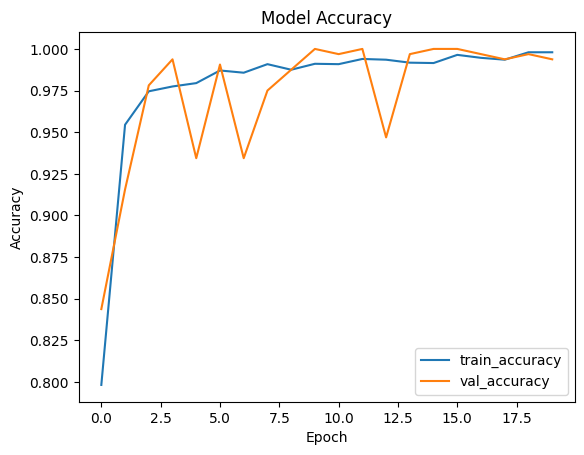

In [ ]:
# Plotting the training and validation accuracy across epochs
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

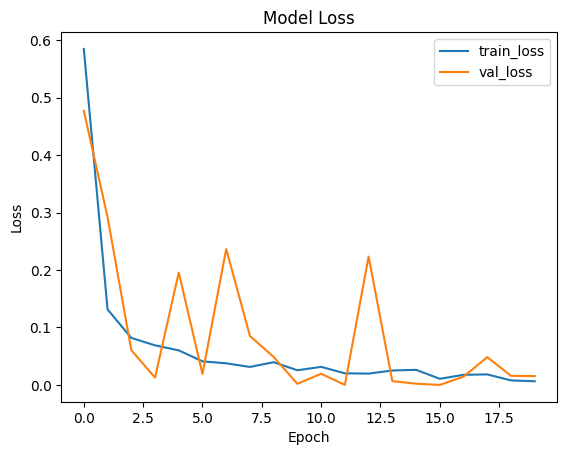

In [ ]:
# Plotting the training and validation loss across epochs
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print(df.columns)


Index(['speech', 'label'], dtype='object')


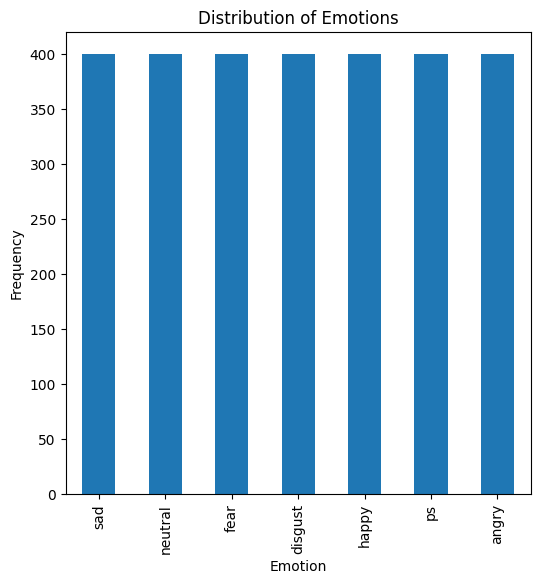

In [ ]:
plt.figure(figsize=(6, 6))
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()
